In [149]:
import glob

all_vehicle_images = [f for f in glob.glob('./vehicles/**/*.png', recursive=True)]
all_non_vehicle_images = [f for f in glob.glob('./non-vehicles/**/*.png', recursive=True)]

vehicle_images = []
for i, vehicle in enumerate(all_vehicle_images):
    if i % 5 == 0:
        vehicle_images.append(vehicle)
        
non_vehicle_images = []
for i, not_vehicle in enumerate(all_non_vehicle_images):
    if i % 5 == 0:
        non_vehicle_images.append(not_vehicle)

In [150]:
print("There are {} vehicle images".format(len(vehicle_images)))
print("There are {} non-vehicle images".format(len(non_vehicle_images)))

There are 1759 vehicle images
There are 1794 non-vehicle images


Image shape: (64, 64, 3)


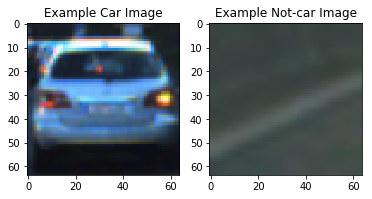

In [151]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in car / not-car images
vehicle_ind = np.random.randint(0, len(vehicle_images))
not_vehicle_ind = np.random.randint(0, len(non_vehicle_images))
vehicle_image = mpimg.imread(vehicle_images[vehicle_ind])
non_vehicle_image = mpimg.imread(non_vehicle_images[not_vehicle_ind])
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(vehicle_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(non_vehicle_image)
plt.title('Example Not-car Image')
print("Image shape: {}".format(vehicle_image.shape))

## Train the Model

In [152]:
sample_size = min(len(vehicle_images), len(non_vehicle_images))
cars = vehicle_images[0:sample_size]
notcars = non_vehicle_images[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

In [153]:
import importlib
from sklearn.preprocessing import StandardScaler
import Feature_Extractor
import Vehicle_Classifier
import Searcher
import Heat_Map
importlib.reload(Feature_Extractor)
importlib.reload(Vehicle_Classifier)
importlib.reload(Searcher)
importlib.reload(Heat_Map)
from Feature_Extractor import Feature_Extractor
from Vehicle_Classifier import Vehicle_Classifier
from Searcher import Searcher
from Heat_Map import Heat_Map

Text(0.5,1,'HOG Visualization')

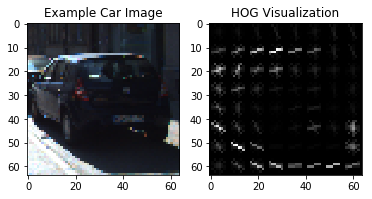

In [180]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(vehicle_images))
# Read in the image
image = mpimg.imread(vehicle_images[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
fe = Feature_Extractor()
features, hog_image = fe.get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [154]:
feature_extractor = Feature_Extractor()

car_features = feature_extractor.extract_features(cars, color_space=color_space, spatial_size=spatial_size, 
                                                  hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                                  cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                                  spatial_feat=spatial_feat, hist_feat=hist_feat, 
                                                  hog_feat=hog_feat)

notcar_features = feature_extractor.extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

In [155]:
vehicle_classifier = Vehicle_Classifier(car_features, notcar_features)
vehicle_classifier.fit()

Feature vector length: 11988
2.66 Seconds to train SVC...
Test Accuracy of SVC =  0.9759


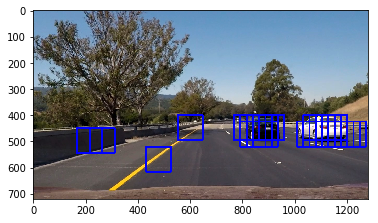

In [156]:
vehicle_searcher = Searcher(feature_extractor)

ystart = 400
ystop = 656
scale = 1.5
X_scaler = vehicle_classifier.X_scaler
img = mpimg.imread('./test_images/test6.jpg')
    
out_img, bboxes = vehicle_searcher.find_cars(img, ystart, ystop, scale, vehicle_classifier.svc, X_scaler, orient,
                                     pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

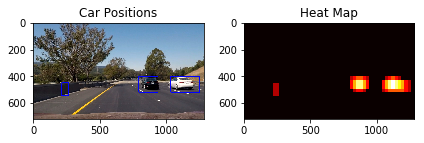

In [157]:
from scipy.ndimage.measurements import label
# Read in image similar to one shown above 
image = img
heat = np.zeros_like(image[:,:,0]).astype(np.float)


# Add heat to each box in box list
heat_map = Heat_Map()
heat = heat_map.add_heat(heat,bboxes)
    
# Apply threshold to help remove false positives
heat = heat_map.apply_threshold(heat,1.7)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = heat_map.draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [158]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [178]:
def get_bounding_boxes(img):
    vehicle_searcher = Searcher(feature_extractor)
    bboxes = []
    ystart = 400
    ystop = 500
    sf = 1.0
    X_scaler = vehicle_classifier.X_scaler

    out_img, bboxes0 = vehicle_searcher.find_cars(img, ystart, ystop, 1.0*sf, vehicle_classifier.svc, X_scaler, 
                                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    out_img, bboxes1 = vehicle_searcher.find_cars(img, ystart, ystop, 1.3, vehicle_classifier.svc, X_scaler, 
                                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    ystart = 410
    ystop = 500
    out_img, bboxes2 = vehicle_searcher.find_cars(img, ystart, ystop, 1.4*sf, vehicle_classifier.svc, X_scaler, 
                                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 420
    ystop = 556
    out_img, bboxes3 = vehicle_searcher.find_cars(img, ystart, ystop, 1.6*sf, vehicle_classifier.svc, X_scaler, 
                                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 430
    ystop = 556
    out_img, bboxes4 = vehicle_searcher.find_cars(img, ystart, ystop, 1.8*sf, vehicle_classifier.svc, X_scaler, 
                                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    out_img, bboxes5 = vehicle_searcher.find_cars(img, ystart, ystop, 2.0*sf, vehicle_classifier.svc, X_scaler, 
                                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 440
    ystop = 556
    out_img, bboxes6 = vehicle_searcher.find_cars(img, ystart, ystop, 1.9*sf, vehicle_classifier.svc, X_scaler, 
                                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    ystart = 400
    ystop = 556
    out_img, bboxes7 = vehicle_searcher.find_cars(img, ystart, ystop, 1.3*sf, vehicle_classifier.svc, X_scaler, 
                                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    out_img, bboxes8 = vehicle_searcher.find_cars(img, ystart, ystop, 2.2*sf, vehicle_classifier.svc, X_scaler, 
                                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 500
    ystop = 656
    out_img, bboxes9 = vehicle_searcher.find_cars(img, ystart, ystop, 3.0*sf, vehicle_classifier.svc, X_scaler, 
                                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    bboxes.extend(bboxes0)
    bboxes.extend(bboxes1)
    bboxes.extend(bboxes2)
    bboxes.extend(bboxes3)
    bboxes.extend(bboxes4)
    bboxes.extend(bboxes5)
    bboxes.extend(bboxes6)
    bboxes.extend(bboxes7)
    bboxes.extend(bboxes8)
    bboxes.extend(bboxes9)
    
    return bboxes

def filter_out_false_positives(heat_map, bboxes, image):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = heat_map.add_heat(heat,bboxes)

    video_frame_history.append(heat)
    heatmaps = sum(video_frame_history)//len(video_frame_history)
    # Apply threshold to help remove false positives
    threshold = 10.0
    heat = heat_map.apply_threshold(heatmaps, threshold)

    # Visualize the heatmap when displaying    
    current_heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmaps)
    draw_img = heat_map.draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

def vehicle_detection_pipeline(image):
    bboxes = get_bounding_boxes(image)
    img = filter_out_false_positives(heat_map, bboxes, image)
    return img
    

In [176]:
from collections import deque

video_frame_history = deque(maxlen=10)

In [177]:

video_output = './video_output/bbox_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(vehicle_detection_pipeline)#.subclip(37, 42) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./video_output/bbox_video.mp4
[MoviePy] Writing video ./video_output/bbox_video.mp4


100%|█████████▉| 1260/1261 [39:31<00:01,  1.92s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./video_output/bbox_video.mp4 

CPU times: user 1h 7min 3s, sys: 3min 18s, total: 1h 10min 22s
Wall time: 39min 33s
